In [58]:
import copy

import numpy as np
import scipy as scp
import matplotlib.pyplot as plt
import json

In [38]:
filename = '/Users/tsievert/GA Caltech/QAE_4_HEP/ga_runs/run-2023-10-24_13-09-45/final_evolution_results.json'

dict = None
with open(filename, 'r') as f: # open in readonly mode
    dict = json.load(f)

In [39]:
print(dict.keys())

dict_keys(['full_population_vectors', 'full_population_drawings', 'final_max_vector_moments', 'full_population_fitness', 'full_tsne_data', 'per_gen_diversity', 'full_pop_diversity', 'current_generation', 'current_drawn_generation', 'current_generation_fitness', 'fitness_stats', 'best_ansatz', 'best_drawn_ansatz', 'best_fitness', 'best_fitness_gen', 'best_fitness_ix', 'full_population_metrics', 'eval_metrics', 'eval_metrics_stats', 'best_eval_metrics'])


In [40]:
full_pop_drawn_circuits = dict['full_population_drawings']
full_pop_fitness = dict['full_population_fitness']
full_pop_auroc = [i['auroc'] for i in dict['full_population_metrics']]
full_tsne_data = dict['full_tsne_data']
per_gen_diversity = dict['per_gen_diversity']

In [41]:
sorted_auroc = [i.item() for i in np.argsort(full_pop_auroc)]

In [42]:
print(f'median is: {np.median(full_pop_auroc)}')
print(f'iqr is: {scp.stats.iqr(full_pop_auroc)}')

median is: 0.8494153846153847
iqr is: 0.16738461538461524


In [43]:
print(f"auroc = {dict['best_eval_metrics']['auroc']}")
print(f"fitness = {dict['best_fitness']}")
print(dict['best_drawn_ansatz'])
print(f"gen = {dict['best_fitness_gen']}, index = {dict['best_fitness_ix']}")

auroc = 0.709374358974359
fitness = 0.9890395
0: ─────╭●─────╭X─────╭●──RZ─┤     
1: ──RX─│───Rϕ─│───RY─│──────┤     
2: ─────╰X─────╰●──Rϕ─╰X─────┤  
gen = 14, index = 1


In [44]:
worst_indeces = sorted_auroc[:]

for circuit_ix in worst_indeces:
    print(f'auroc = {full_pop_auroc[circuit_ix]}')
    print(f"fitness = {full_pop_fitness[circuit_ix]}")
    print(full_pop_drawn_circuits[circuit_ix])
    print(f'\n{"-"*40}\n')

auroc = 0
fitness = 0
0: ────────────────────────────────┤ 
1: ────────────────────────────────┤ 
2: ────────────────────────────────┤  

----------------------------------------

auroc = 0.06691282051282052
fitness = 0.9571485
0: ─────╭X──RX─────╭●─────┤     
1: ──RX─│───RZ──Rϕ─│──────┤     
2: ─────╰●─────────╰X──RX─┤  

----------------------------------------

auroc = 0.10036923076923077
fitness = 0.354244
0: ──RX─╭●─────╭X──RZ─┤     
1: ──RY─│───Rϕ─│──────┤     
2: ─────╰X─────╰●──RX─┤  

----------------------------------------

auroc = 0.10687179487179488
fitness = 0.6676934999999999
0: ─╭X──────╭X──RX─────┤     
1: ─╰●───RX─│───Rϕ─────┤     
2: ──RY─────╰●──RX──RZ─┤  

----------------------------------------

auroc = 0.10982564102564102
fitness = 0.30671099999999996
0: ─╭X─╭●─────╭X─────────┤     
1: ─╰●─│───RX─│──────────┤     
2: ────╰X──RX─╰●──Rϕ──RZ─┤  

----------------------------------------

auroc = 0.12188717948717949
fitness = 0.914887
0: ──RX─────╭●──RX─────┤     
1

In [138]:
import ga_vqc as gav

gates_dict = {"I": (1, 0), "RX": (1, 1), "RY": (1, 1), "RZ": (1, 1), "PhaseShift": (1, 1), "CNOT": (2, 0)}
gates_probs = [0.15, 0.15, 0.15, 0.15, 0.15, 0.25]
genepool = gav.Genepool(gates_dict, gates_probs)

full_pop_circuits = []
for diagram in full_pop_drawn_circuits:
    full_pop_circuits.append(gav.Individual(3, 1, 1, genepool, rng_seed=None, diagram=diagram))

max_vector_moments = 0
for circuit in full_pop_circuits:
    if circuit.n_moments > max_vector_moments:
        max_vector_moments = circuit.n_moments

for circuit in full_pop_circuits:
    circuit.generate_vector(max_vector_moments)

In [139]:
## Euclidean Distances ##

euc_distances = []

for i in range(len(full_pop_circuits)):
    euc_distances.append(gav.euclidean_distances(full_pop_circuits[i], full_pop_circuits[0], full_pop_circuits[1:]))
euc_distances = np.array(euc_distances)
euc_distances = np.hstack(([[0]]+[[1] for _ in range(len(full_pop_circuits)-1)], euc_distances))

euc_cutoff_threshold = 0.9
euc_groupings = []
set_of_euc_picked = set()

for i in range(1, len(full_pop_circuits)):
    if i in set_of_euc_picked:
        continue
    current_group = [i]
    set_of_euc_picked.add(i)

    for j in range(1, len(full_pop_circuits)):
        if j <= i or j in set_of_euc_picked:
            continue
        
        add_flag = True
        for k in current_group:
            if euc_distances[k, j] >= euc_cutoff_threshold:
                add_flag = False
        if add_flag:
            current_group.append(j)
            set_of_euc_picked.add(j)

    euc_groupings.append(copy.deepcopy(current_group))

In [140]:
for group in euc_groupings:    
    for j in group:
        print('-'*30)
        print(f'fitness = {full_pop_fitness[j]:.03f}, auroc = {full_pop_auroc[j]:.03f}')
        print(full_pop_drawn_circuits[j])
    print('='*50)

------------------------------
fitness = 0.810, auroc = 0.689
0: ──Rϕ──RY─────────┤     
1: ─────╭●───RY─────┤     
2: ──RY─╰X───RX──Rϕ─┤  
------------------------------
fitness = 0.802, auroc = 0.868
0: ──Rϕ─╭X──────────────┤     
1: ─────╰●───RZ──Rϕ──RZ─┤     
2: ──RY──RZ──RX──Rϕ─────┤  
------------------------------
fitness = 0.802, auroc = 0.877
0: ─────╭●──RZ─────┤     
1: ──RZ─│───Rϕ─────┤     
2: ─────╰X──Rϕ──RZ─┤  
------------------------------
fitness = 0.878, auroc = 0.870
0: ─────╭●─────────┤     
1: ──RZ─│──────────┤     
2: ─────╰X──RX──RY─┤  
------------------------------
fitness = 0.754, auroc = 0.871
0: ─────╭X─────────┤     
1: ──RZ─│───Rϕ─────┤     
2: ─────╰●──RZ──RY─┤  
------------------------------
fitness = 0.909, auroc = 0.873
0: ──RY──RX─┤     
1: ──RX─────┤     
2: ──Rϕ──RX─┤  
------------------------------
fitness = 0.031, auroc = 0.575
0: ──Rϕ──RX─┤     
1: ──RX──RZ─┤     
2: ──Rϕ──RX─┤  
------------------------------
fitness = 0.738, auroc = 0.874
0: 

In [151]:
ordering = []
set_of_picked = set()

ordering.append(0)
set_of_picked.add(0)

for _ in range(len(euc_groupings)-1):
    avg_arr = []
    for j in range(len(euc_groupings)):
        avg_distances = []
        for m in euc_groupings[ordering[-1]]:
            distances = []
            for n in euc_groupings[j]:
                distances.append(euc_distances[m, n])
            avg_distances.append(np.mean(distances).item())
        
        avg_arr.append(np.mean(avg_distances).item())
    
    index_avg_arr = np.argsort(avg_arr)
    for j in index_avg_arr:
        if j in set_of_picked:
            continue
        ordering.append(j)
        set_of_picked.add(j)
        break

In [141]:
## String Distances ##

str_distances = []

for i in range(len(full_pop_circuits)):
    str_distances.append(gav.string_distances(full_pop_circuits[i], full_pop_circuits[0].diagram, full_pop_circuits[1:]))
str_distances = np.array(str_distances)
str_distances = np.hstack(([[0]]+[[1] for _ in range(len(full_pop_circuits)-1)], str_distances))

str_cutoff_threshold = 0.7
str_groupings = []
set_of_str_picked = set()

for i in range(1, len(full_pop_circuits)):
    if i in set_of_str_picked:
        continue
    current_group = [i]
    set_of_str_picked.add(i)

    for j in range(1, len(full_pop_circuits)):
        if j <= i or j in set_of_str_picked:
            continue
        
        add_flag = True
        for k in current_group:
            if str_distances[k, j] >= str_cutoff_threshold:
                add_flag = False
        if add_flag:
            current_group.append(j)
            set_of_str_picked.add(j)

    str_groupings.append(copy.deepcopy(current_group))

AttributeError: module 'ga_vqc' has no attribute 'string_distances'

In [ ]:
for group in str_groupings:    
    for j in group:
        print('-'*30)
        print(f'fitness = {full_pop_fitness[j]:.03f}, auroc = {full_pop_auroc[j]:.03f}')
        print(full_pop_drawn_circuits[j])
    print('='*50)

In [145]:
import matplotlib as mpl

cmap = plt.cm.jet # define the colormap
# extract all colors from the .jet map
cmaplist = [cmap(i) for i in range(cmap.N)]

# create the new map
cmap = mpl.colors.LinearSegmentedColormap.from_list(
    'Custom cmap', cmaplist, cmap.N)

# define the bins and normalize
bounds = np.linspace(0, len(euc_groupings)-1, len(euc_groupings))
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)



<style>

</style>

<div id="fig_el604681405872020469447855954774"></div>
<script>
function mpld3_load_lib(url, callback){
  var s = document.createElement('script');
  s.src = url;
  s.async = true;
  s.onreadystatechange = s.onload = callback;
  s.onerror = function(){console.warn("failed to load library " + url);};
  document.getElementsByTagName("head")[0].appendChild(s);
}

if(typeof(mpld3) !== "undefined" && mpld3._mpld3IsLoaded){
   // already loaded: just create the figure
   !function(mpld3){
       
       mpld3.draw_figure("fig_el604681405872020469447855954774", {"width": 640.0, "height": 480.0, "axes": [{"bbox": [0.125, 0.10999999999999999, 0.775, 0.77], "xlim": [-0.07093707500000021, 1.0395145749999999], "ylim": [-0.045134358974358975, 0.9478215384615385], "xdomain": [-0.07093707500000021, 1.0395145749999999], "ydomain": [-0.045134358974358975, 0.9478215384615385], "xscale": "linear", "yscale": "linear", "axes": [{"position": "bottom", "nticks": 8, "tickvalues": null, "ti

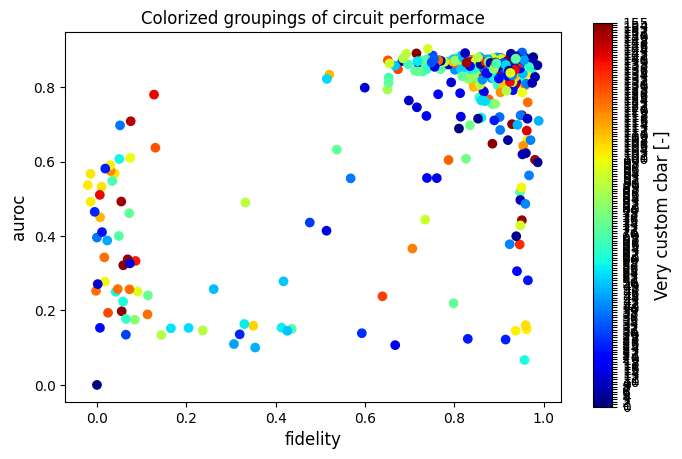

In [157]:
import mpld3

tags = [0 for _ in range(len(full_pop_auroc))]
for i in range(len(full_pop_auroc)):
    found_flag = False
    for k in range(len(euc_groupings)):
        if found_flag:
            break
        for j in euc_groupings[k]:
            if j == i:
                return_index = 0
                for m in range(len(euc_groupings)):
                    if ordering[m] == k:
                        return_index = m
                        break
                found_flag = True
                tags[i] = m
                break


fig, ax = plt.subplots()
# fig = plt.figure()
points = ax.scatter(full_pop_fitness, full_pop_auroc, c=tags,
    cmap=cmap, norm=norm)
# points = plt.scatter(full_pop_fitness, full_pop_auroc, marker='.')
ax2 = fig.add_axes([0.95, 0.1, 0.03, 0.8])
cb = mpl.colorbar.ColorbarBase(ax2, cmap=cmap, norm=norm,
    spacing='proportional', ticks=bounds, boundaries=bounds, format='%1i')

ax.set_title('Colorized groupings of circuit performace')
ax2.set_ylabel('Very custom cbar [-]', size=12)
ax.set_xlabel('fidelity', size=12)
ax.set_ylabel('auroc', size=12)
# plt.xlabel('fidelity')
# plt.ylabel('auroc')

mpld3.plugins.connect(fig, mpld3.plugins.PointLabelTooltip(points, [(i, j) for i, j in zip(range(len(full_pop_auroc)), tags)]))

html = mpld3.fig_to_html(fig)
print(html)

mpld3.save_html(fig, 'interactive_scatter.html')

In [ ]:
# line1_indeces = [293, 205, 186, 280, 172, 110, 1, 184, 203, 174, 275, 138, 330, 346, 361, 415, 299]
line1_indeces = [293, 205, 186, 280, 171, 172, 110, 1, 184, 203]
line2_indeces = [418, 357, 100, 331, 227]
line3_indeces = [30, 254, 372, 5, 156, 72, 409, 33, 394]

lines = [line1_indeces, line2_indeces, line3_indeces]

In [ ]:
for line in lines:
    for i in line:
        print('-'*30)
        print(f'fitness = {full_pop_fitness[i]:.03f}, auroc = {full_pop_auroc[i]:.03f}')
        print(full_pop_drawn_circuits[i])
    print('='*50)

------------------------------
fitness = 0.593, auroc = 0.139
0: ────────╭X──RY─╭●──┤     
1: ─╭●──RX─│───Rϕ─╰X──┤     
2: ─╰X─────╰●──RY──RZ─┤  
------------------------------
fitness = 0.639, auroc = 0.238
0: ─╭X─╭●──────╭●────┤     
1: ─│──╰X───RX─│──╭●─┤     
2: ─╰●──RZ─────╰X─╰X─┤  
------------------------------
fitness = 0.706, auroc = 0.366
0: ──RZ─┤     
1: ──RX─┤     
2: ──Rϕ─┤  
------------------------------
fitness = 0.735, auroc = 0.444
0: ─────╭X──RZ──Rϕ─┤     
1: ──RY─│───RX─────┤     
2: ─────╰●──RZ─────┤  
------------------------------
fitness = 0.739, auroc = 0.556
0: ─╭X─────╭X──RX─────┤     
1: ─╰●──RX─│───RZ─────┤     
2: ────────╰●──RX──RZ─┤  
------------------------------
fitness = 0.761, auroc = 0.556
0: ────────╭X──RX─┤     
1: ─╭X──RX─│──────┤     
2: ─╰●─────╰●──Rϕ─┤  
------------------------------
fitness = 0.787, auroc = 0.604
0: ──RZ────────╭X─┤     
1: ─╭●──╭X──RY─│──┤     
2: ─╰X──╰●─────╰●─┤  
------------------------------
fitness = 0.810, auroc = 